# Galaxies: An interactive graduate course

## Chapter 2.2: SDSS: Magnitudes, spectra, and colors

#### (c) Benedikt Diemer, University of Maryland (based on similar notebooks by Andrey Kravtsov, University of Chicago)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 2.2.1) Apparent magnitudes

Let's plot the filter bands used in SDSS to get a first sense of what redshifts the survey covers and what the magnitudes actually mean. The data tables can be downloaded from the SDSS website ([link](https://classic.sdss.org/dr7/instruments/imager/filters/)), and they are included in our data directory.

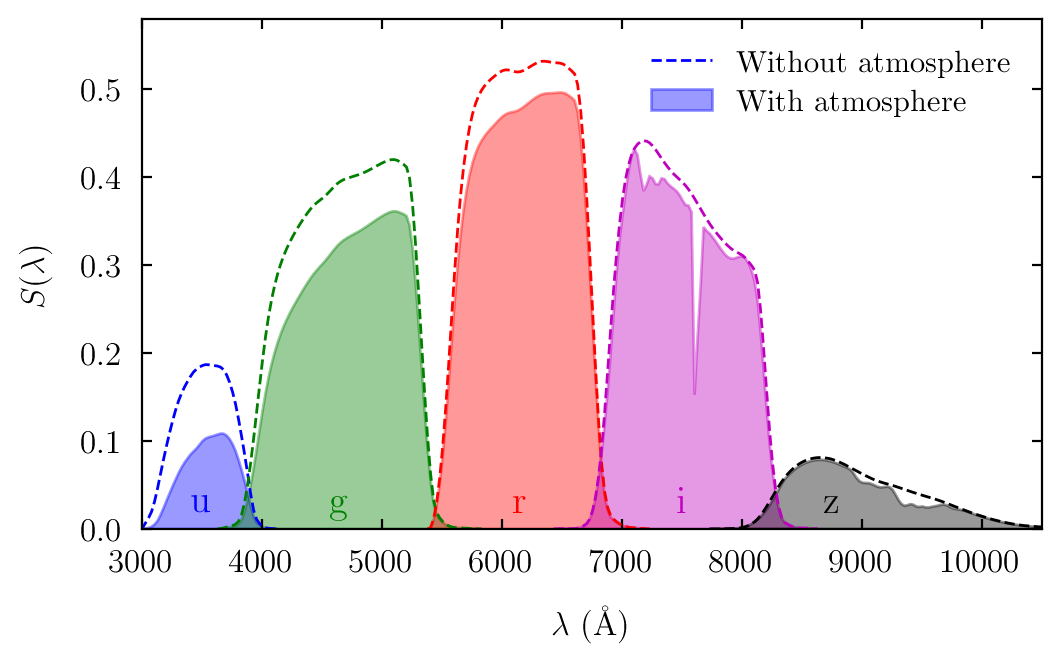

In [2]:
import os

plt.figure(figsize = (6.0, 3.4))
plt.xlim(3000, 10500)
plt.ylim(0, 0.58)
plt.xlabel(r'$\lambda\ ({\rm \AA})$')
plt.ylabel(r'$S(\lambda)$')
for i, f, c, loc in zip([0, 1, 2, 3, 4], 'ugriz', 'bgrmk', [3500, 4650, 6150, 7500, 8750]):
    fn = cmn.data_dir + 'sdss/filter_%c.txt' % (f)
    if not os.path.exists(fn):
        raise ValueError('Could not find file %s.' % fn)
    filt = np.loadtxt(fn, unpack = True)
    if i == 0:
        label1 = r'$\mathrm{Without\ atmosphere}$'
        label2 = r'$\mathrm{With\ atmosphere}$'
    else:
        label1 = None
        label2 = None
    plt.plot(filt[0], filt[3], color = c, ls = '--', lw = 1.0, label = label1)
    plt.fill(filt[0], filt[2], ec = c, fc = c, alpha = 0.4, label = label2)
    plt.text(loc, 0.03, f, color = c, ha = 'center', va = 'center', fontsize = 14)
plt.legend()
plt.show()

Its noteworthy that the filter transmission is always below 50% even at the centers of the filters, so quite a bit of light is lost due to the filtering process. The atmosphere (difference between dashed lines and filled areas) additionally removes some light especially in the UV, as well as a particular line in the IR ($i$ filter). See the [SDSS docs](https://www.sdss3.org/instruments/camera.php#Filters) for more information. Let's load our SDSS data file as previously and look for definitions of magnitude:

In [3]:
from routines import obs_sdss

data = obs_sdss.loadSdssSpecSample()

print('Found %d galaxies with the following fields:' % (len(data)))
for i in range(len(data.columns.names)):
    print(data.columns.names[i])

Found 673232 galaxies with the following fields:
ra
dec
mjd
plate
fiberID
class
z
zErr
rChi2
velDisp
velDispErr
extinction_u
extinction_g
extinction_r
extinction_i
extinction_z
fiberMag_u
fiberMag_g
fiberMag_r
fiberMag_i
fiberMag_z
modelMag_u
modelMag_g
modelMag_r
modelMag_i
modelMag_z
cmodelMag_u
cmodelMag_g
cmodelMag_r
cmodelMag_i
cmodelMag_z
phioffset_r
fracdeV_r
deVRad_r
deVRadErr_r
deVAB_r
deVABErr_r
deVPhi_r
lnLDeV_r
deVMag_r
deVMagErr_r
expRad_r
expRadErr_r
expAB_r
expABErr_r
expPhi_r
lnLExp_r
expMag_r
expMagErr_r
petroMag_u
petroMag_g
petroMag_r
petroMag_i
petroMag_z
petroRad_u
petroRad_g
petroRad_r
petroRad_i
petroRad_z
petroR50_r
petroR90_r
petroR50Err_r
petroR90Err_r
h_alpha_flux
h_alpha_flux_err
oiii_5007_flux
oiii_5007_flux_err
d4000
d4000_err
bptclass
lgm_tot_p50
sfr_tot_p50
objID
specObjID


Clearly, we have lots of different magnitudes in this list, for example ``petroMag_r``, ``expMag_r``, ``deVMag_r``, ``modelMag_r``, and ``cmodelMag_r``. These names refer to different extents within which we can measure the luminosity, but we'll come back to the details later. For now, we just plot a histogram of the distribution of different magnitude definitions. We will generally plot magnitudes on inverted axes so that flux increases to the right.

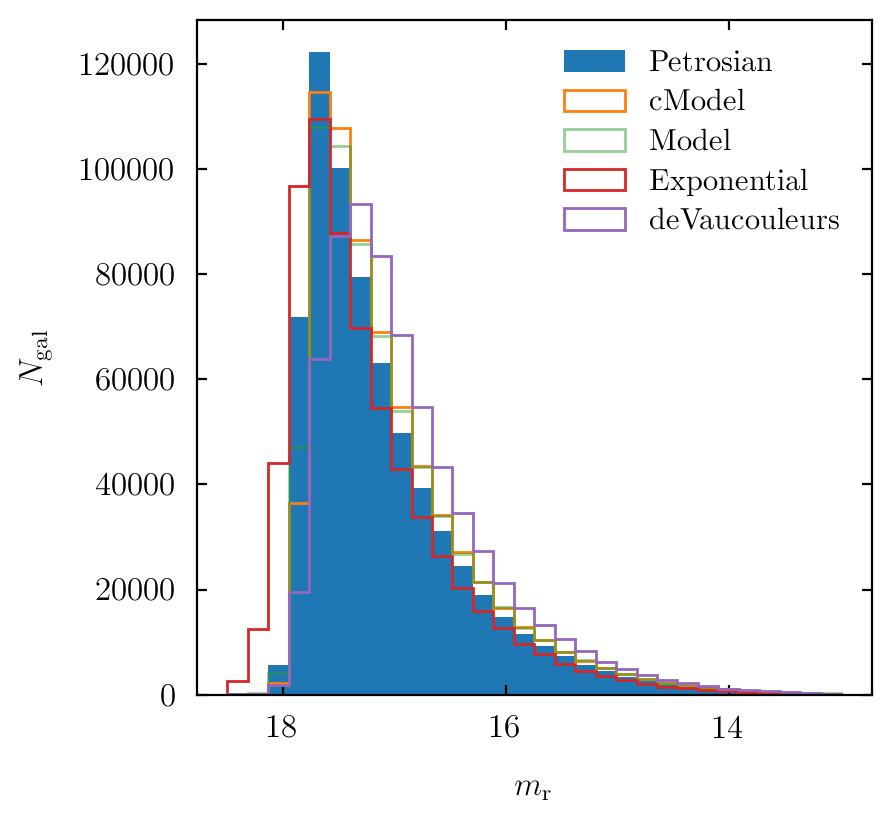

In [4]:
plt.figure()
plt.gca().invert_xaxis()
plt.xlabel(r'$m_{\rm r}$')
plt.ylabel(r'$N_{\rm gal}$')
hist_args = dict(range = [13.0, 18.5], bins = 30)
plt.hist(data['petroMag_r'], histtype = 'stepfilled', label = r'$\mathrm{Petrosian}$', **hist_args)
plt.hist(data['cmodelMag_r'], histtype = 'step', label = r'$\mathrm{cModel}$', **hist_args)
plt.hist(data['modelMag_r'], histtype = 'step', alpha = 0.5, label = r'$\mathrm{Model}$', **hist_args)
plt.hist(data['expMag_r'], histtype = 'step', label = r'$\mathrm{Exponential}$', **hist_args)
plt.hist(data['deVMag_r'], histtype = 'step', label = r'$\mathrm{de Vaucouleurs}$', **hist_args)
plt.legend()
plt.show()

Clearly, our SDSS dataset is more or less magnitude-limited around 18 or so.

### 2.2.2) - 2.2.3) Absolute magnitudes and dust extinction

The apparent magnitudes in the figure above tell us little about the galaxy population in our sample. We need to convert apparent to absolute magnitudes by adding 1) the distance modulus and 2) the dust extinction correction. The Milky Way dust extinction for each galaxy and filter band is given in the SDSS dataset:

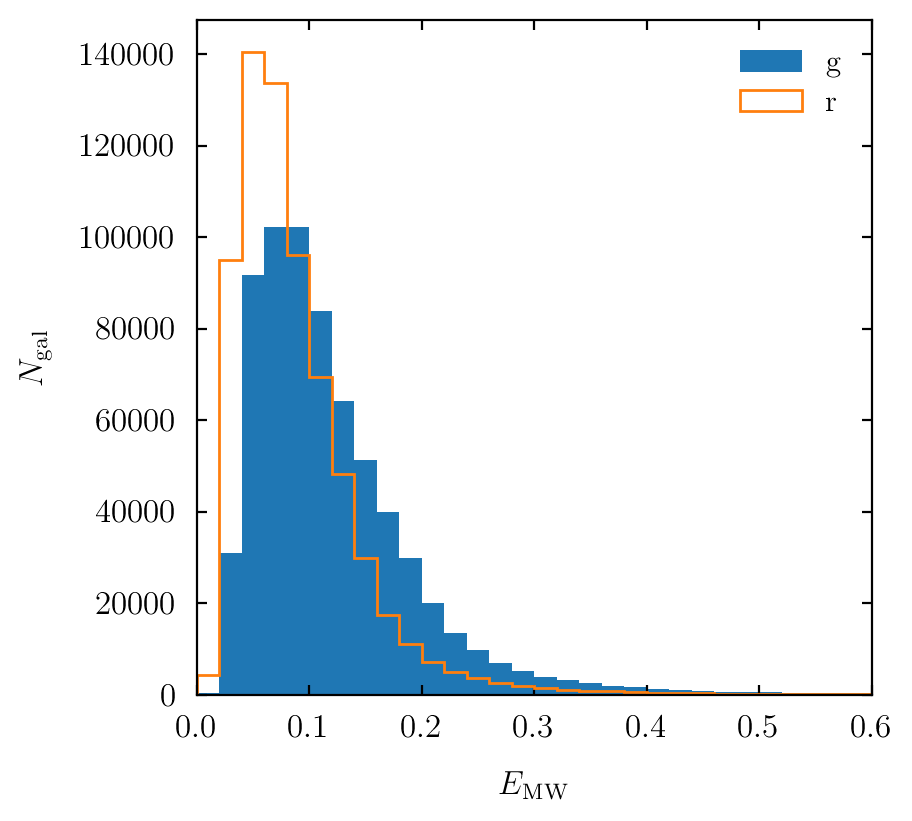

In [5]:
hist_args = dict(range = [0.0, 0.6], bins = 30)

plt.figure()
plt.xlabel(r'$E_{\rm MW}$')
plt.ylabel(r'$N_{\rm gal}$')
plt.xlim(0.0, 0.6)
plt.hist(data['extinction_g'], histtype = 'stepfilled', label = r'$\mathrm{g}$', **hist_args)
plt.hist(data['extinction_r'], histtype = 'step', label = r'$\mathrm{r}$', **hist_args)
plt.legend()
plt.show()

Unsurprisingly, the extinction in $g$ is higher than in $r$, since bluer wavelengths are absorbed more efficiently. How much of the light is absorbed? We can take the median g-band extinction as an indicator and convert it to luminosity:

In [6]:
f_absorbed = 1.0 - 10**(-0.4 * np.median(data['extinction_g']))
print('%.1f%% of g-band light is absorbed for the typical galaxy.' % (100.0 * f_absorbed))

9.0% of g-band light is absorbed for the typical galaxy.


We note the tail towards very strong extinction though. Clearly, we should not neglect this factor. We subtract it, in addition to extinction, to compute absolute magnitudes:

Maximum difference between Colossus and our formula is 1.4e-14
99% of the galaxy population lie between Mr = -14.61 and -23.52, a range of 8.9 magnitudes, 3.6 orders of mag. in luminosity.


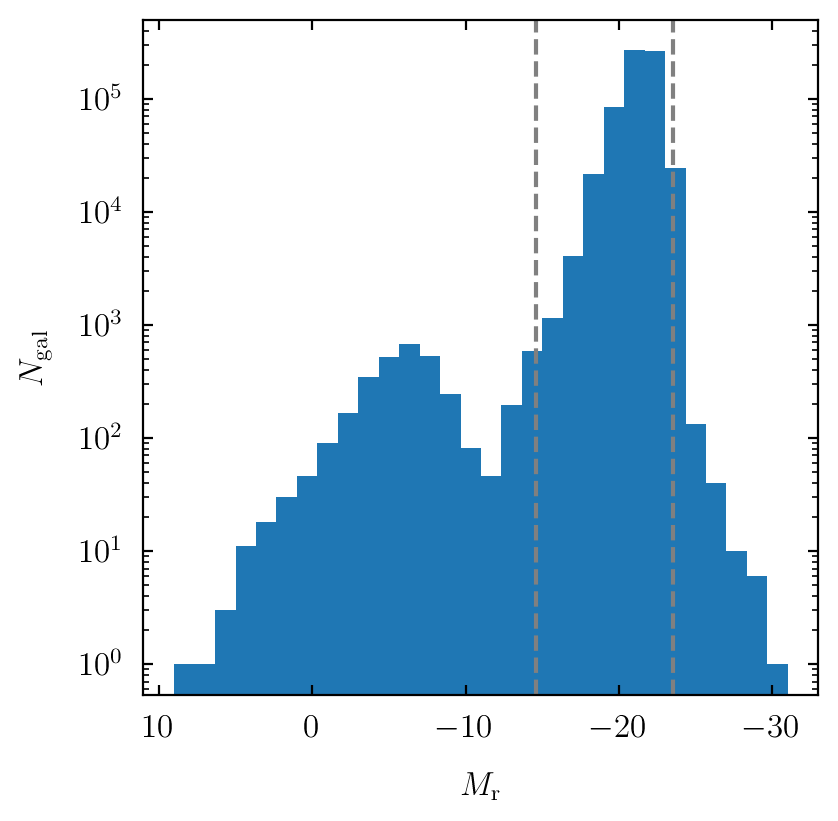

In [7]:
from colossus.cosmology import cosmology

# Compute luminosity distance and distance modulus and compare the latter to Colossus.
# Note that Colossus returns dL in Mpc/h, whereas we want to compare to 10pc.
cosmo = cosmology.getCurrent()
dL = cosmo.luminosityDistance(data['z']) / cosmo.h
dm_manual = 5.0 * np.log10(dL * 1E6 / 10.0)
dm = cosmo.distanceModulus(data['z'])
max_diff = np.max(np.abs(dm - dm_manual))
print('Maximum difference between Colossus and our formula is %.1e' % max_diff)

# Compute absolute magnitude (ignoring K-corrections for now)
M_r_cmodel = data['modelMag_r'] - data['extinction_r'] - dm
perc_low = np.percentile(M_r_cmodel, 99.5)
perc_high = np.percentile(M_r_cmodel, 0.5)
mag_range = perc_low - perc_high
print('99%% of the galaxy population lie between Mr = %.2f and %.2f, a range of %.1f magnitudes, %.1f orders of mag. in luminosity.' \
        % (perc_low, perc_high, mag_range, 0.4 * mag_range))

hist_args = dict(range = [-31.0, 9.0], bins = 30)

plt.figure()
plt.gca().invert_xaxis()
plt.xlabel(r'$M_{\rm r}$')
plt.ylabel(r'$N_{\rm gal}$')
plt.hist(M_r_cmodel, histtype = 'stepfilled', log = True, **hist_args)
plt.axvline(perc_low, ls = '--', color = 'gray')
plt.axvline(perc_high, ls = '--', color = 'gray')
plt.show()

Even though the distribution is wide, the logarithmic histogram can be misleading: 99% of the objects classified as galaxies lie between magnitudes of -14.6 and -23.5 or so. We also print that this corresponds to a range of 9 magnitudes, or 3.6 orders of magnitude in luminosity. That seems reasonable.

### 2.2.4) $K$-corrections

In principle, we can now get galaxy colors by comparing magnitudes in two filters. However, to do this (and computing $M$) properly, we need to add $K$-corrections. Let us explore what the uncorrected distribution of $g-r$ color looks like. Note that distance modulus does not matter since it would be the same for both magnitudes. We use "model" magnitudes here because they are measured from the same surface brightness fit in all filters.

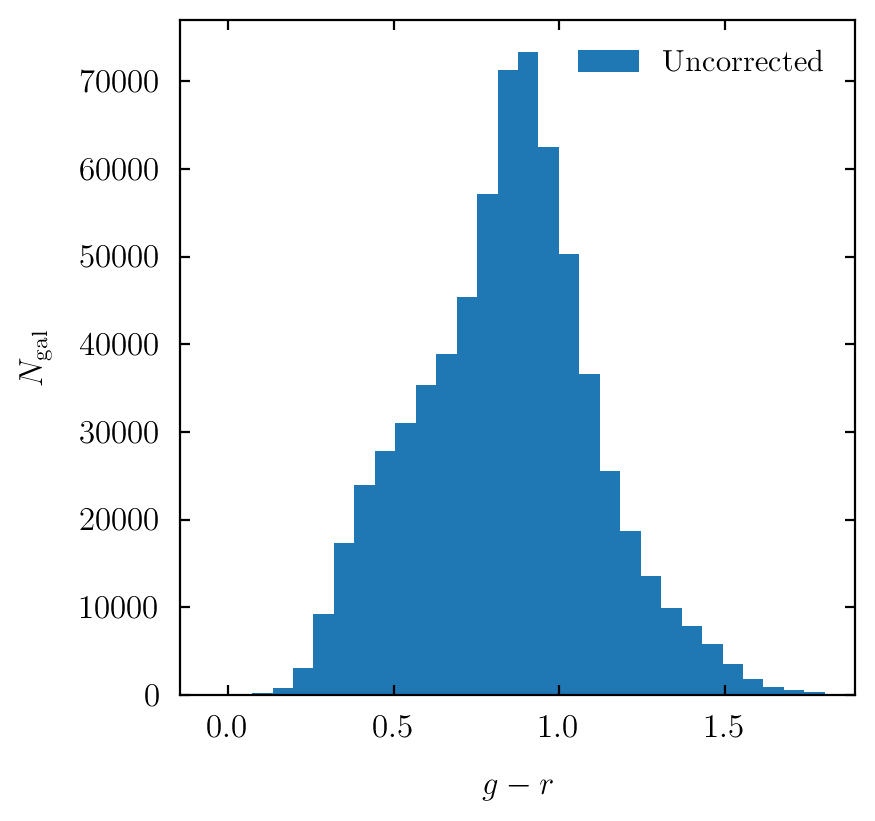

In [8]:
mu = data['modelMag_u'] - data['extinction_u']
mg = data['modelMag_g'] - data['extinction_g']
mr = data['modelMag_r'] - data['extinction_r']
mi = data['modelMag_i'] - data['extinction_i']
mz = data['modelMag_z'] - data['extinction_z']

gr_uncor = mg - mr

plt.figure()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$N_{\rm gal}$')
plt.hist(gr_uncor, histtype = 'stepfilled', label = r'$\mathrm{Uncorrected}$', bins = 30, range = [-0.05, 1.8])
plt.legend()
plt.show()

Let's now see how significant the $K$-corrections are for this range of color. We use the approximate fitting functions of Chilingarian et al. 2010, which are part of our code routines (taken from their [website](http://kcor.sai.msu.ru/getthecode/)). The fits are only calibrated up to $z = 0.6$. We plot both the results for the $g$ and $r$ filters:

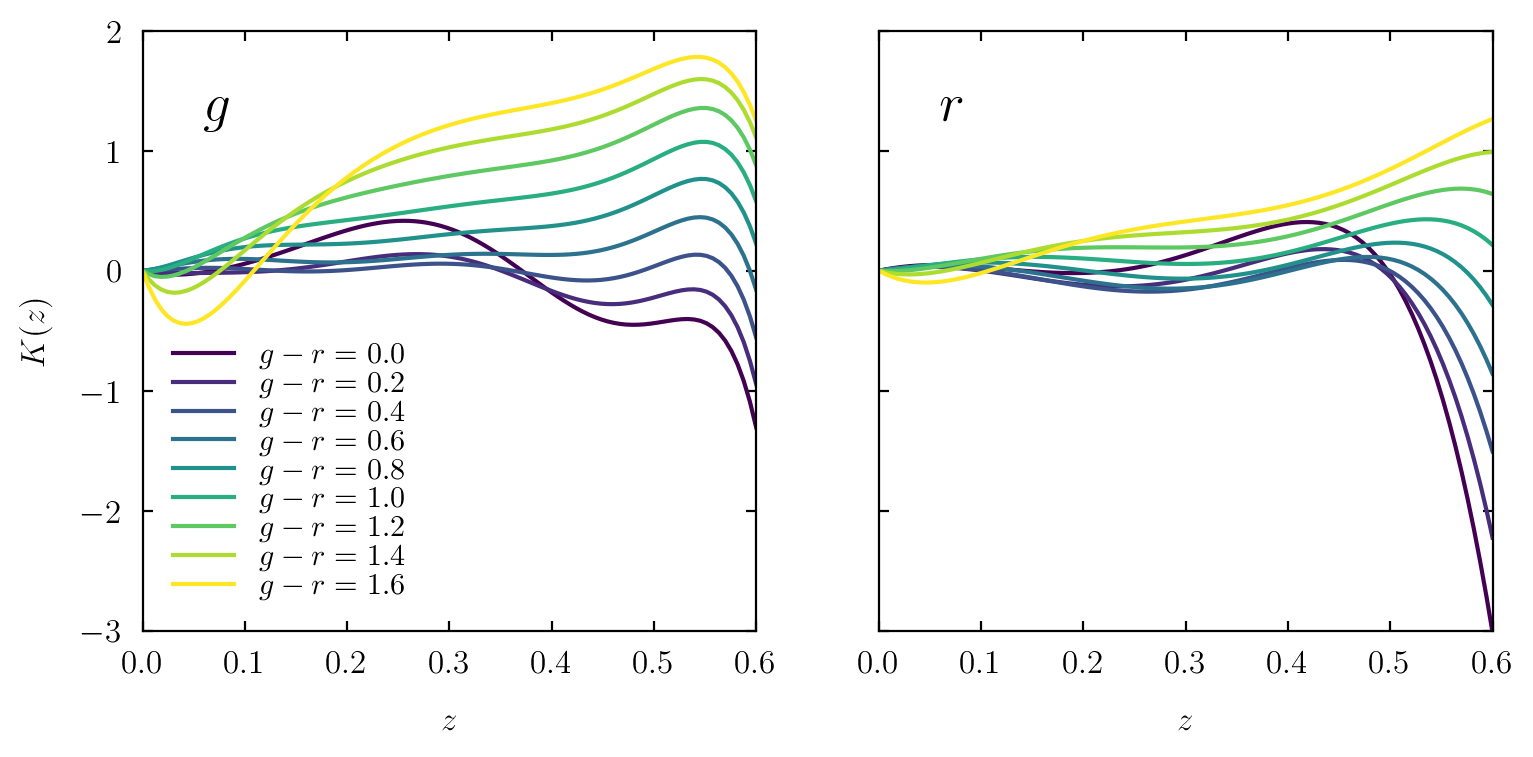

In [9]:
from routines import obs_utils

z = np.linspace(0.0, 0.6, 100)
gr = np.linspace(0.0, 1.6, 9)
cmap = plt.get_cmap('viridis')

fig, axes = plt.subplots(1, 2, figsize = (9.0, 4.0))

plt.sca(axes[0])
plt.text(0.1, 0.85, r'$g$', fontsize = 20, transform = plt.gca().transAxes)
for i in range(len(gr)):
    c = cmap(i / (len(gr) - 1))
    K = obs_utils.kCorrection('g', z, 'g-r', gr[i])
    plt.plot(z, K, c = c, label = r'$g-r = %.1f$' % (gr[i]))
plt.legend(labelspacing = 0.05)

plt.sca(axes[1])
plt.text(0.1, 0.85, r'$r$', fontsize = 20, transform = plt.gca().transAxes)
for i in range(len(gr)):
    c = cmap(i / (len(gr) - 1))
    K = obs_utils.kCorrection('r', z, 'g-r', gr[i])
    plt.plot(z, K, c = c)

for ax in axes:
    plt.sca(ax)
    plt.xlabel(r'$z$')
    plt.xlim(0.0, 0.6)
    plt.ylim(-3.0, 2.0)
axes[0].set_ylabel(r'$K(z)$')
axes[1].set_yticklabels([])
plt.show()

We note that the $K$-corrections look quite different in the $g$ and $r$ filters, which tells us that they will probably shift the $g-r$ color significantly. Before we look at that, let's quickly look at the distribution of the $K$-corrections themselves in our SDSS sample. There are a few galaxies with $z > 0.6$ in our sample, for which the formulae are not calibrated. We cut out those galaxies, as well as strong outliers in our uncorrected color distribution above, to avoid extreme $K$-corrections.

The formulae for the $K$-corrections allow us to calculate the corrections for some filters from multiple uncorrected input colors. If the assumptions about galaxy spectra made in the fitting functions are realistic and self-consistent, then the $K$-corrections computed from different colors but for the same filter should be very similar. We check this by computing the $K$-correction for $r$ from both $g-r$ and $u-r$ and that for $g$ from $g-r$, from $g-i$, and from $g-z$. We plot histograms of the $K$-corrections themselves and of the differences between the different estimates.

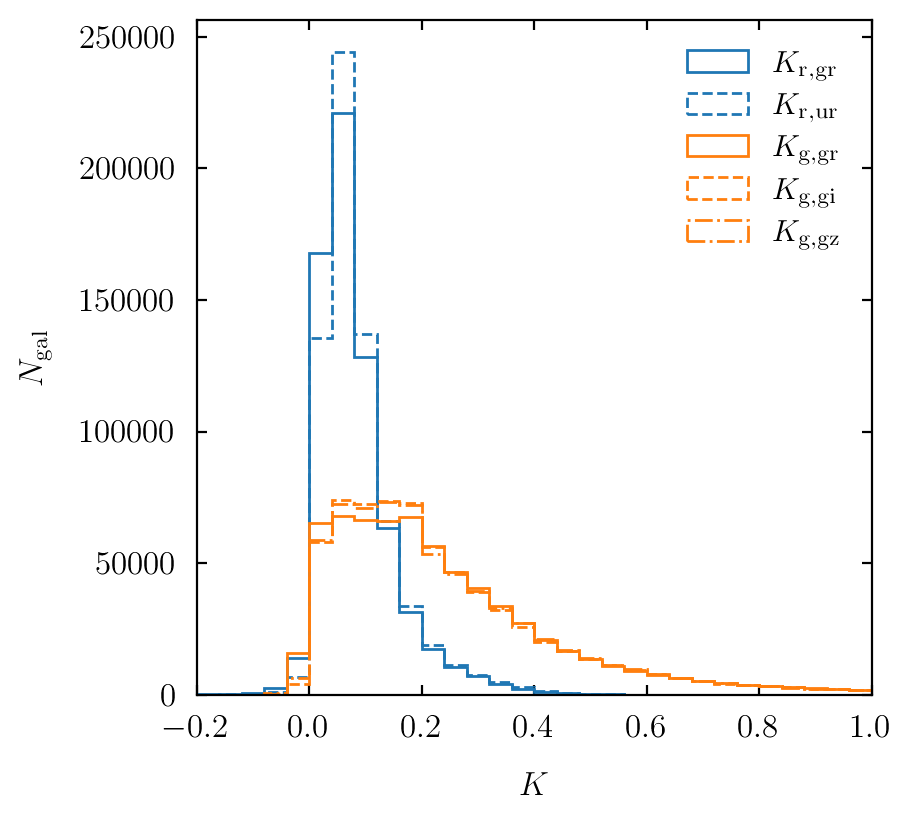

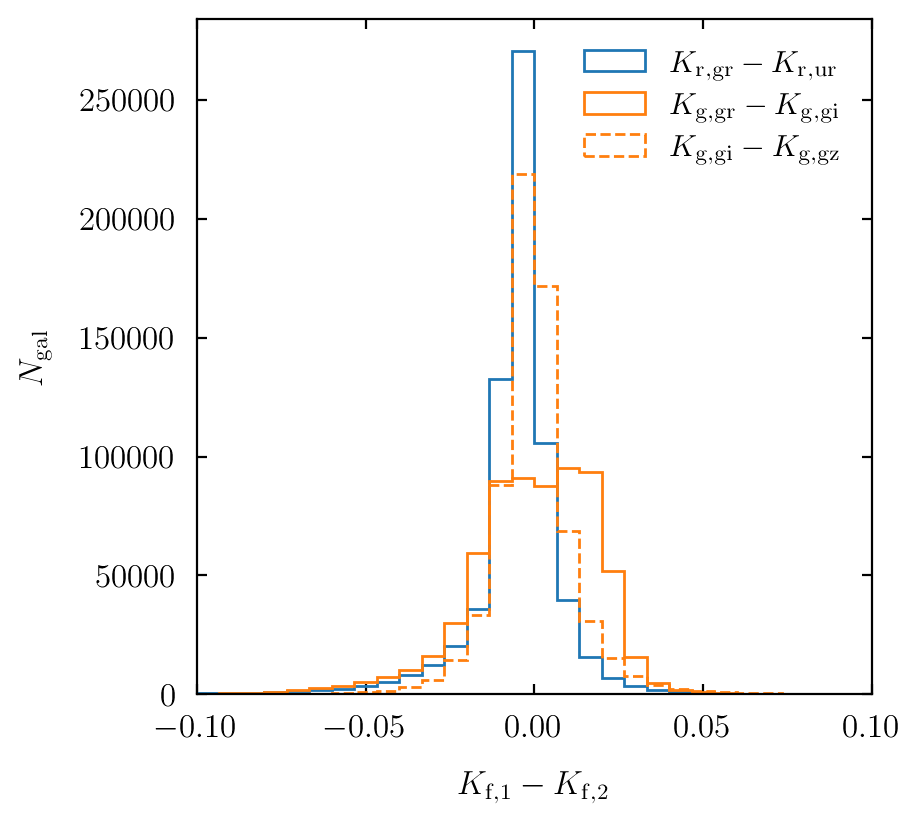

In [10]:
mask = (gr_uncor > -0.5) & (gr_uncor < 2.0) & (data['z'] <= 0.6)
data = data[mask]
dm = dm[mask]
dL = dL[mask]
mu = mu[mask]
mg = mg[mask]
mr = mr[mask]
mi = mi[mask]
mz = mz[mask]

ur_uncor = mu - mr
gr_uncor = mg - mr
gi_uncor = mg - mi
gz_uncor = mg - mz

K_r_gr = obs_utils.kCorrection('r', data['z'], 'g-r', gr_uncor)
K_r_ur = obs_utils.kCorrection('r', data['z'], 'u-r', ur_uncor)
K_g_gr = obs_utils.kCorrection('g', data['z'], 'g-r', gr_uncor)
K_g_gi = obs_utils.kCorrection('g', data['z'], 'g-i', gi_uncor)
K_g_gz = obs_utils.kCorrection('g', data['z'], 'g-z', gz_uncor)

plt.figure()
plt.xlabel(r'$K$')
plt.ylabel(r'$N_{\rm gal}$')
plt.xlim(-0.2, 1.0)
hist_args = dict(log = False, bins = 30, range = [-0.2, 1.0])
plt.hist(K_r_gr, histtype = 'step', ls = '-',  label = r'$K_{\rm r,gr}$', color = cmn.color_cycle[0], **hist_args)
plt.hist(K_r_ur, histtype = 'step', ls = '--', label = r'$K_{\rm r,ur}$', color = cmn.color_cycle[0], **hist_args)
plt.hist(K_g_gr, histtype = 'step', ls = '-',  label = r'$K_{\rm g,gr}$', color = cmn.color_cycle[1], **hist_args)
plt.hist(K_g_gi, histtype = 'step', ls = '--', label = r'$K_{\rm g,gi}$', color = cmn.color_cycle[1], **hist_args)
plt.hist(K_g_gz, histtype = 'step', ls = '-.', label = r'$K_{\rm g,gz}$', color = cmn.color_cycle[1], **hist_args)
plt.legend()
plt.show()

plt.figure()
plt.xlabel(r'$K_{\rm f,1} - K_{\rm f,2}$')
plt.ylabel(r'$N_{\rm gal}$')
plt.xlim(-0.1, 0.1)
hist_args = dict(log = False, bins = 30, range = [-0.1, 0.1])
plt.hist(K_r_gr - K_r_ur, histtype = 'step', ls = '-',  label = r'$K_{\rm r,gr} - K_{\rm r,ur}$', color = cmn.color_cycle[0], **hist_args)
plt.hist(K_g_gr - K_g_gi, histtype = 'step', ls = '-',  label = r'$K_{\rm g,gr} - K_{\rm g,gi}$', color = cmn.color_cycle[1], **hist_args)
plt.hist(K_g_gi - K_g_gz, histtype = 'step', ls = '--', label = r'$K_{\rm g,gi} - K_{\rm g,gz}$', color = cmn.color_cycle[1], **hist_args)
plt.legend()
plt.show()

The $K$-correction for $r$ is mostly small because our sample is dominated by low redshifts. For $g$, the corrections are larger even at small $z$ (see plot above), so the distribution is broader. The different input colors make a small difference (much less than $0.05$ mags in the vast majority of galaxies), which is reassuring. We can now check how the $K$-corrections affect our $g-r$ color distribution:

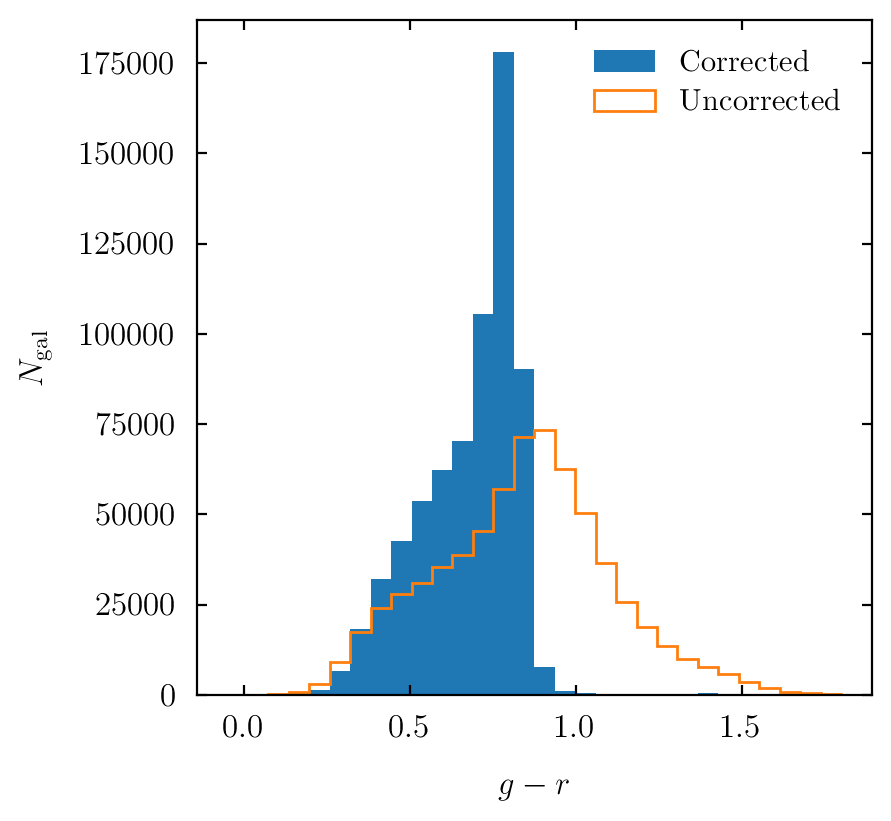

In [11]:
gr_cor = (data['modelMag_g'] - data['extinction_g'] - K_g_gr) \
    - (data['modelMag_r'] - data['extinction_r'] - K_r_gr)

hist_args = dict(bins = 30, range = [-0.05, 1.8])

plt.figure()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$N_{\rm gal}$')
plt.hist(gr_cor, histtype = 'stepfilled', label = r'$\mathrm{Corrected}$', **hist_args)
plt.hist(gr_uncor, histtype = 'step', label = r'$\mathrm{Uncorrected}$', **hist_args)
plt.legend()
plt.show()

The K-corrections make a huge difference! The tail towards $g-r > 1$ seems to have been caused by the lack of $K$-corrections. However, we should note that the plot above still does not reflect the true color distribution of galaxies because color is correlated with the total luminosity of galaxies. Thus, we are strongly biased towards the colors of the largest galaxies, which we can see from farther away. We will try to recover the true color distribution in a later notebook.

Finally, we are now in a position to compute absolute magnitudes including $K$-corrections. On plots of $M_{\rm g}$ or $M_{\rm r}$, the difference does not look too impressive given the modest $K$-corrections compared to the absolute magnitude, but it still matters.

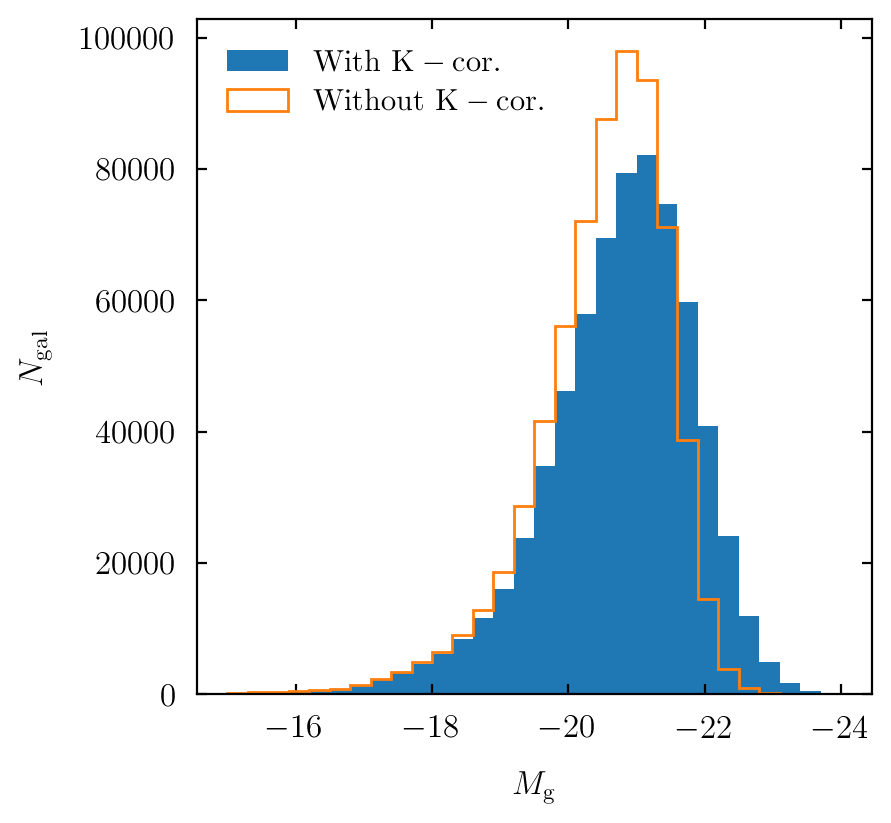

In [12]:
M_r_kcor = data['modelMag_r'] - data['extinction_r'] - dm - K_r_gr
M_g_no_kcor = data['modelMag_g'] - data['extinction_g'] - dm
M_g_kcor = M_g_no_kcor - K_g_gr

hist_args = dict(range = [-24.0, -15], bins = 30, log = False)

plt.figure()
plt.gca().invert_xaxis()
plt.xlabel(r'$M_{\rm g}$')
plt.ylabel(r'$N_{\rm gal}$')
plt.hist(M_g_kcor, histtype = 'stepfilled', label = r'$\mathrm{With\ K-cor.}$', **hist_args)
plt.hist(M_g_no_kcor, histtype = 'step', label = r'$\mathrm{Without\ K-cor.}$', **hist_args)
plt.legend()
plt.show()

### 2.2.5) Spectrum and color

Let's get a sense of how the spectrum of galaxies relates to the filters in which we compute magnitudes. We can download spectra in FITS files from the SDSS data servers, similar to images. The spectra are technically from DR7 (see [docs](https://das.sdss.org/www/html/das2.html) page), but that's not an issue. We plot image, spectrum, and filters next to each other: 

We select six different bins in color, where we use "fiber" magnitudes that correspond to the relatively small area at the center of the galaxies that are covered by the SDSS fibers (about 3'', or 5 pixels in the images below since we set the image scale to 0.6''/pixel).

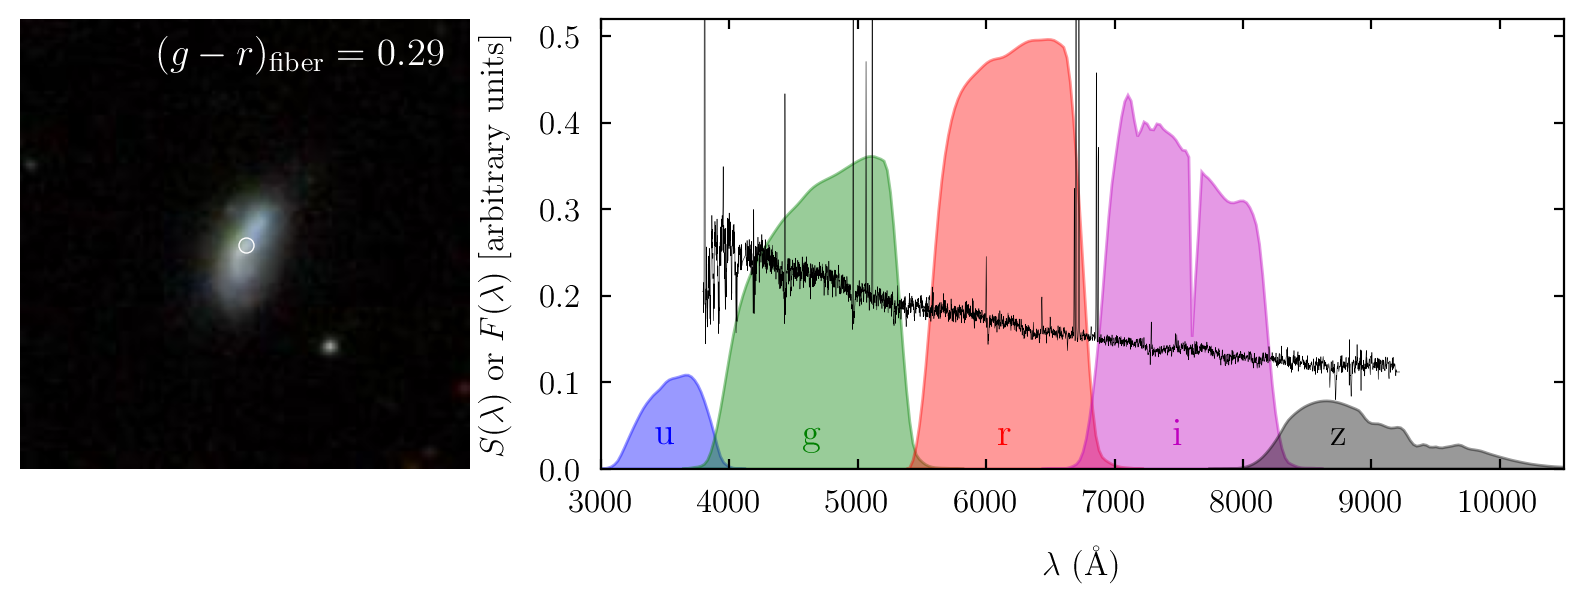

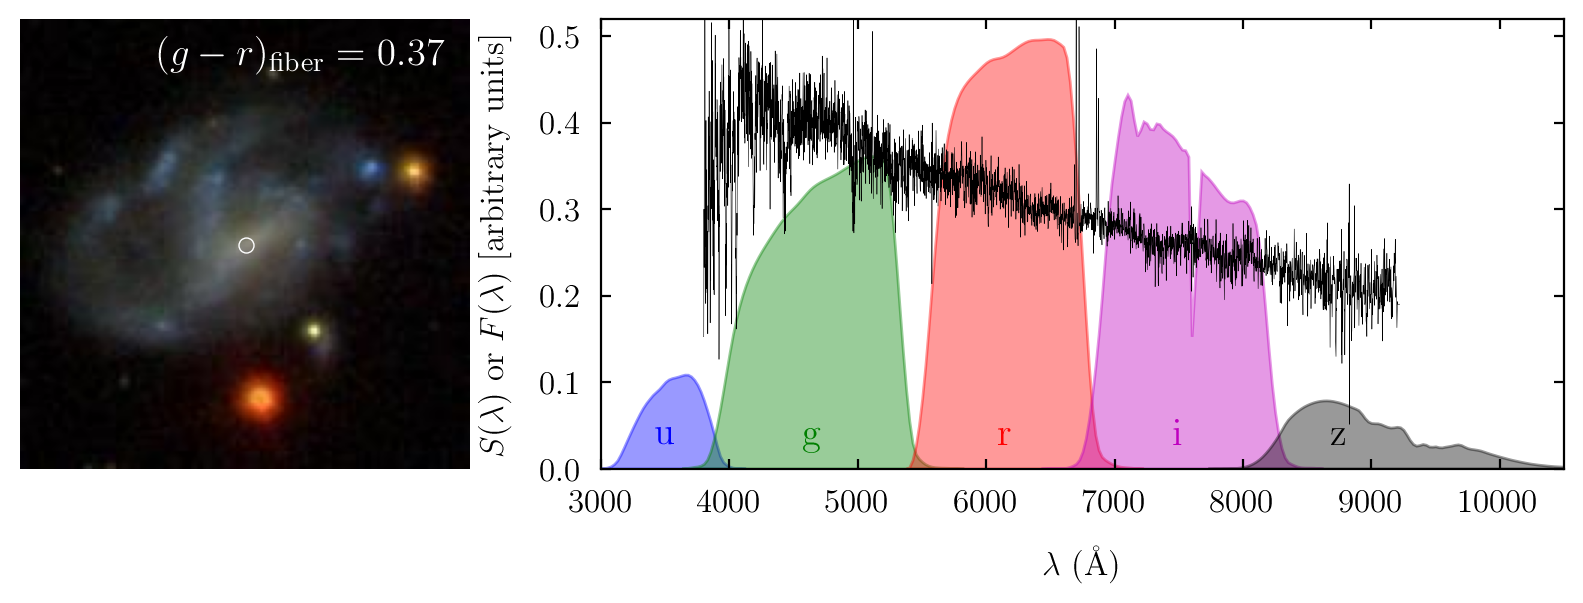

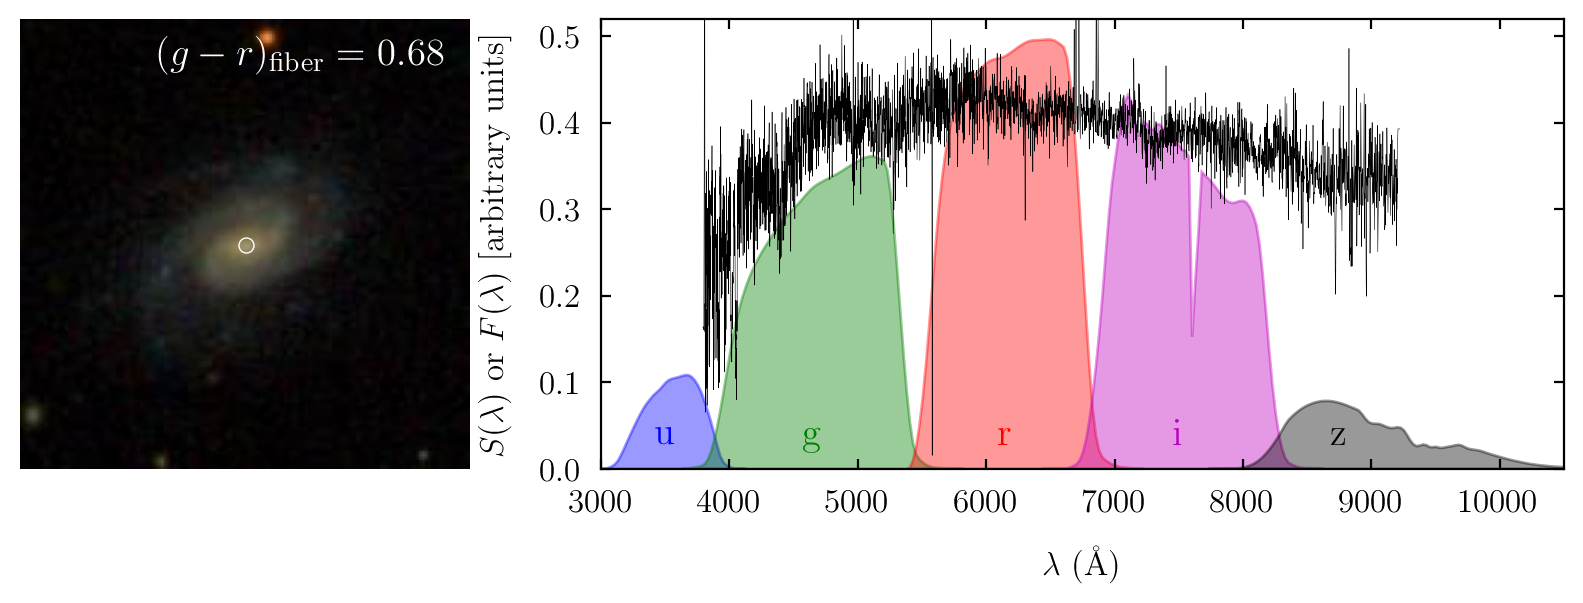

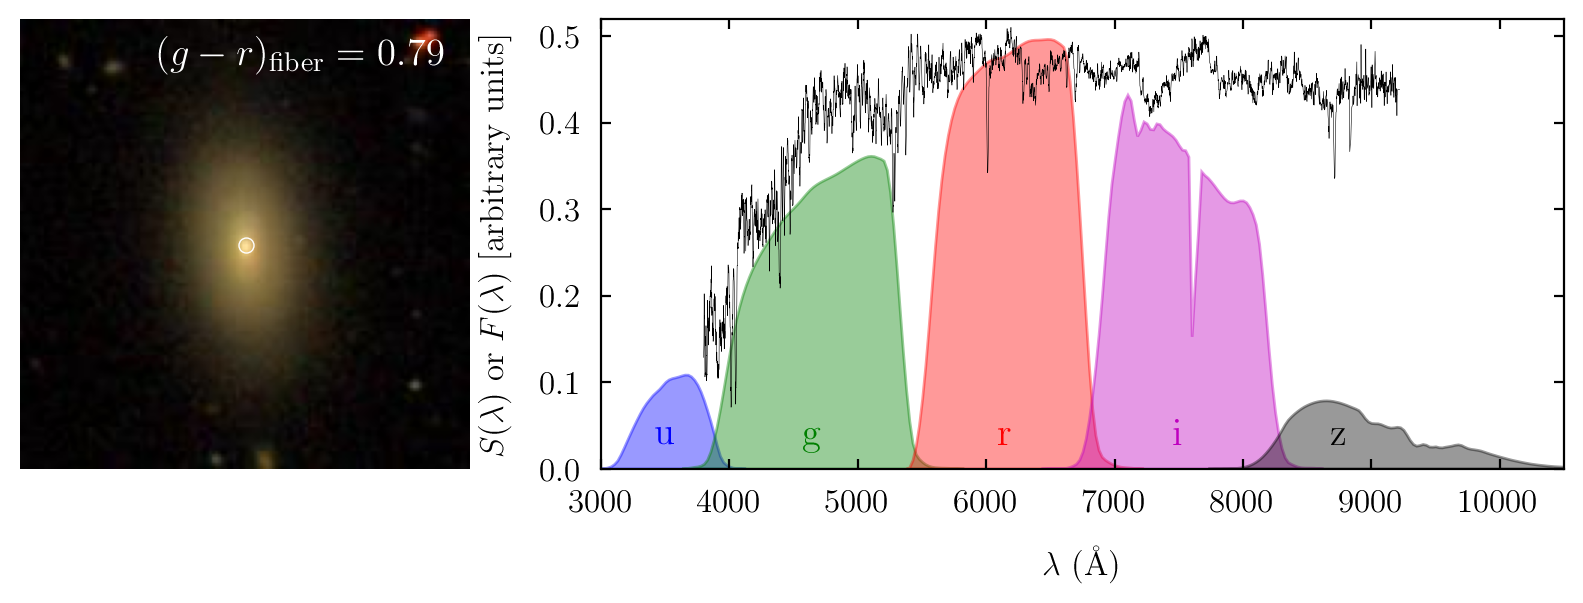

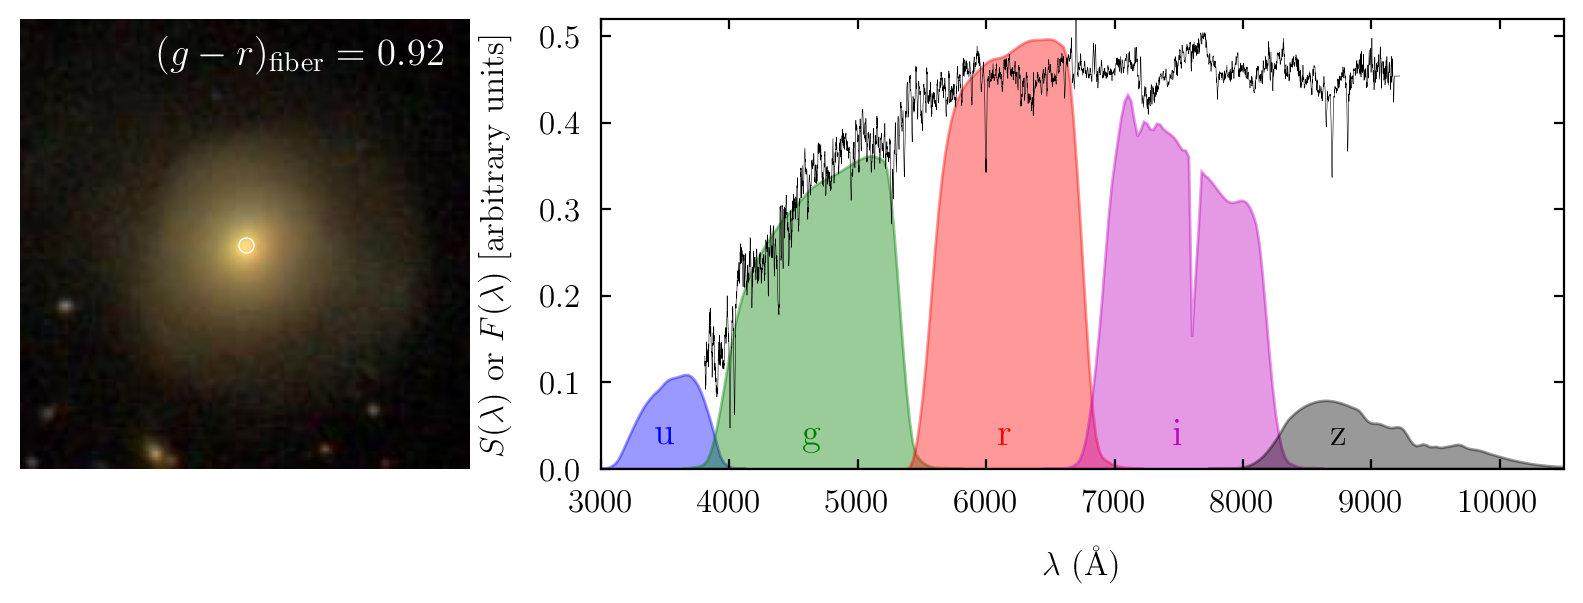

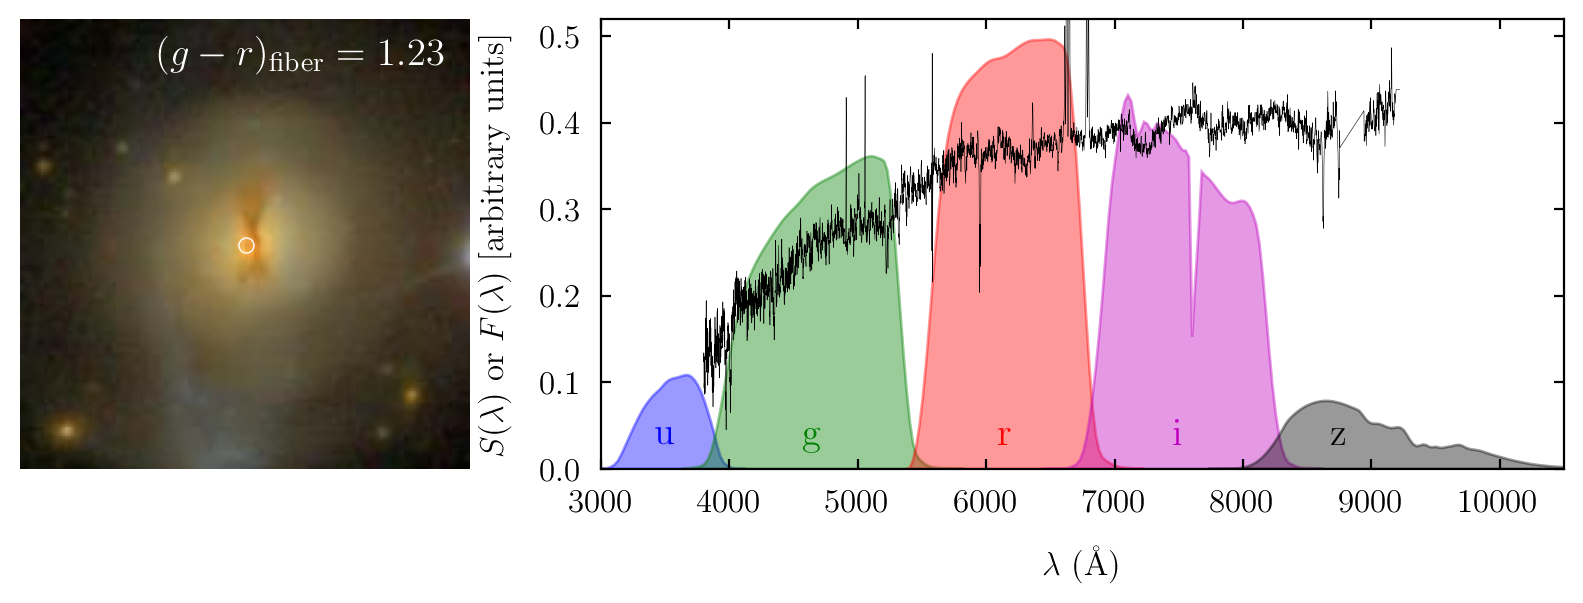

In [13]:
color_bin_edges = [0.0, 0.3, 0.5, 0.7, 0.9, 1.1, 2.0]
np.random.seed(2023)

n_color_bins = len(color_bin_edges) - 1
gr_fib = data['fiberMag_g'] - data['fiberMag_r']
color_cat = np.zeros((n_color_bins, 4), float)
color_int = np.zeros((n_color_bins, 4), float)

idxs_chosen = []
for i in range(n_color_bins):
    idxs = np.where((M_r_kcor < -20.0) & (dL <= 100.0) \
                    & (gr_fib >= color_bin_edges[i]) & (gr_fib <= color_bin_edges[i + 1]))[0]
    idx = np.random.choice(idxs, 1)[0]
    idxs_chosen.append(idx)
    obs_sdss.imageAndSpectrum(data[idx], scale = 0.6, save = False, fn_out = 'sdss_image_spec_%d.pdf' % i)

We see a clear correspondence between the colors at the center of the galaxies and their spectra. In principle, we should be able to recover the magnitudes measured from the spectrum and filter bands. We don't expect a perfect match since the fiber magnitudes do not exactly correspond to the light that enters the spectrograph fibers. In practice, getting the normalization right is tricky, but we can compute the colors (for which the overall normalization does not matter). For the same galaxies that we plotted above, we integrate the spectrum over the filter bands. 

In [14]:
import scipy.integrate
from colossus.utils import constants

idxs = np.array(idxs_chosen)

print('       u-g        |         g-r        |         r-i        |         i-z')
print('cat   int   diff  |  cat   int   diff  |  cat   int   diff  |  cat   int   diff')

for i in range(len(idxs)):
    
    # Load spectrum data
    idx = idxs[i]
    lbda, F = obs_sdss.getSdssSpectrum(data['objID'][idx], data['plate'][idx], 
                                         data['mjd'][idx], data['fiberID'][idx])

    mags = np.zeros(5)
    for j in range(5):
        
        # Load filter
        f = 'ugriz'[j]
        fn = cmn.data_dir + 'sdss/filter_%c.txt' % (f)
        filt = np.loadtxt(fn, unpack = True)

        # Compute the magnitude by integrating the spectrum over the filter. We first interpolate
        # the filter onto the spectrum's wavelength grid. The 1E-8 factor comes from the Angstrom
        # units of the spectra.
        mask = (lbda > filt[0][0]) & (lbda < filt[0][-1])
        lbda_filt = lbda[mask]
        S_lbda = np.interp(lbda_filt, filt[0], filt[2])
        integ_flux = 1E-8 * scipy.integrate.simpson(F[mask] * S_lbda * lbda_filt, x = lbda_filt, even = 'avg')
        integ_norm = scipy.integrate.simpson(S_lbda / lbda_filt, x = lbda_filt, even = 'avg')
        mags[j] = -2.5 * np.log10(10**19.44 / constants.C * integ_flux / integ_norm)

    ug_cat = data['fiberMag_u'][idx] - data['fiberMag_g'][idx]
    gr_cat = data['fiberMag_g'][idx] - data['fiberMag_r'][idx]
    ri_cat = data['fiberMag_r'][idx] - data['fiberMag_i'][idx]
    iz_cat = data['fiberMag_i'][idx] - data['fiberMag_z'][idx]

    ug_int = mags[0] - mags[1]
    gr_int = mags[1] - mags[2]
    ri_int = mags[2] - mags[3]
    iz_int = mags[3] - mags[4]
    
    print('%.2f  %.2f  %+.2f |  %.2f  %.2f  %+.2f |  %.2f  %.2f  %+.2f |  %.2f  %.2f  %+.2f' \
          % (ug_cat, ug_int, ug_int - ug_cat, 
             gr_cat, gr_int, gr_int - gr_cat,
             ri_cat, ri_int, ri_int - ri_cat,
             iz_cat, iz_int, iz_int - iz_cat))

       u-g        |         g-r        |         r-i        |         i-z
cat   int   diff  |  cat   int   diff  |  cat   int   diff  |  cat   int   diff
0.78  0.18  -0.60 |  0.29  0.34  +0.05 |  0.18  0.16  -0.01 |  0.22  0.16  -0.06
1.21  0.57  -0.64 |  0.37  0.38  +0.01 |  0.21  0.20  -0.01 |  0.13  0.12  -0.01
1.41  0.90  -0.51 |  0.68  0.72  +0.03 |  0.33  0.33  -0.01 |  0.23  0.19  -0.04
1.81  1.35  -0.46 |  0.79  0.83  +0.04 |  0.40  0.39  -0.01 |  0.30  0.28  -0.02
1.89  1.40  -0.49 |  0.92  0.95  +0.03 |  0.43  0.44  +0.01 |  0.34  0.30  -0.04
1.86  1.12  -0.74 |  1.23  1.01  -0.22 |  0.65  0.48  -0.17 |  0.60  0.33  -0.27


Integrating the spectra does a pretty good job of matching the fiber colors in $g-r$ and $r-i$. In the extreme bands ($u$ and $z$) we have more trouble, but that is not surprising given that the spectra do not fully cover those bands. The last galaxy is an outlier, probably because of the extremely dusty-looking center, where the fiber magnitudes may not match the actual spectrum very well.